## Data Preparation

In [1]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from astropy.io import fits
from copy import deepcopy
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%pylab inline
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
from tqdm import tqdm
import viz_2d as viz
import cd
import score_funcs
import bandpass_filter
# plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from data import *
data_path = '/scratch/users/vision/data/cosmo'
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  oj(data_path, 'z1_256'))

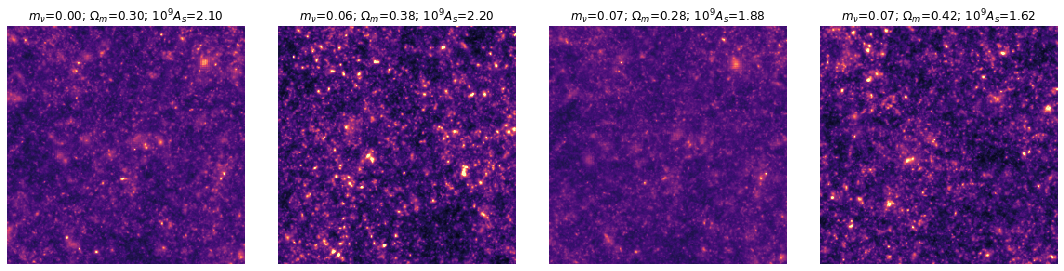

In [3]:
plt.figure(figsize=(15,5))
for i in range(len(mnu_dataset)):
    sample = mnu_dataset[i]

    #print(i, sample['image'].shape, sample['params'].shape)

    subplot(1, 4, i + 1)
    tight_layout()
    axis('off')
    imshow(squeeze(sample['image']), cmap='magma',vmax=0.15,vmin=-0.05 )
    title(r"$m_\nu$=%0.2f; $\Omega_m$=%0.2f; $10^9A_s$=%0.2f"%(sample['params'][0], sample['params'][1], sample['params'][2] ) )

    if i == 3:
        break

## Load the model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import time
import os
import copy



# Modifying the model to predict the three cosmological parameters from single channel images
model_ft = models.resnet18(pretrained=False)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(oj(data_path, 'resnet18_state_dict')))
model_ft.eval()


# vgg
# model_ft = models.vgg16(pretrained=False)
# model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# num_ftrs = 4096 # model_ft.fc.n_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, 3)
# model_ft = model_ft.to(device)
# model_ft.load_state_dict(torch.load(oj(data_path, 'vgg16_big_lr_1_0.107')))
# model_ft.eval()

cuda:0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
data_transform = transforms.Compose([
        ToTensor()
    ])
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                              oj(data_path, 'z1_256'),
                              transform=data_transform)
dataloader = torch.utils.data.DataLoader(mnu_dataset, batch_size=64, 
                                         shuffle=True, num_workers=4)

# check that it makes reasonable preds

In [6]:
device = 'cuda'
model_ft = model_ft.to(device)
with torch.no_grad():
    for data in dataloader:
        inputs, params = data['image'], data['params']
        inputs = inputs.to(device)
        params = params.to(device)
        outputs = model_ft(inputs)
        break

Text(0, 0.5, 'predicted param')

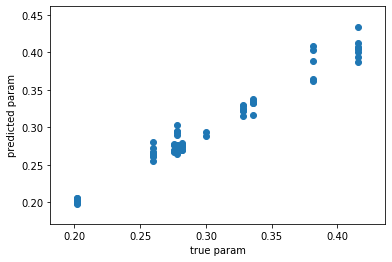

In [7]:
scatter(params.cpu()[:,1], outputs.cpu()[:,1])
xlabel('true param')
ylabel('predicted param')

# analyze one prediction

In [8]:
sample = mnu_dataset[1]
im = np.squeeze(sample['image'])
im_t = torch.Tensor(im).reshape(1, 1, 256, 256)

In [ ]:

# plt.figure(dpi=200)

# #print(i, sample['image'].shape, sample['params'].shape)

# # subplot(1, 4, i + 1)
# # tight_layout()
# axis('off')

# plt.imshow(im, cmap='magma', vmax=0.15, vmin=-0.05)
# plt.show()

# # imshow(squeeze(sample['image']), cmap='magma',vmax=0.15,vmin=-0.05 )
# # title(r"$m_\nu$=%0.2f; $\Omega_m$=%0.2f; $10^9A_s$=%0.2f"%(sample['params'][0], sample['params'][1], sample['params'][2] ) )

# # if i == 3:
# #     break

In [9]:
import util
t = util.Transforms()

t.sigma = 5e-1 # [0, 1]
# t.sigma = 1e-1
# t.sigma = 1e-9
# transform = t.gaussian_filter
# transform = t.bandpass_filter_approx
transform = t.bandpass_filter
# util.visualize(im, transform)

**calc cd scores**

In [ ]:
class_num = 1 # Omega_m
    
# output is: [M_nu(eV), Omega_m 10^9*A_s, sigma_8(derived)]
with torch.no_grad():
    x = deepcopy(im_t).to(device)
    model_ft = model_ft.to(device)
    # transform = t.bandpass_filter_approx
    transform = t.bandpass_filter

    scores = []
    sigmas = np.linspace(0.11, 0.89, 120)
    for sigma in tqdm(sigmas):
        t.sigma = sigma
        score = cd.cd(x, model_ft, mask=None, model_type='resnet18', 
              device='cuda', transform=transform)[0].flatten()[class_num].item()
        scores.append(score)

    # plot
    plt.figure(dpi=150)
    plt.plot(sigmas, scores, 'o-')
    plt.xlabel('frequency band $\pm 0.1$')
    # plt.xscale('log')
    plt.ylabel('cd score')
    plt.show()    

In [50]:
with torch.no_grad():
    x = deepcopy(im_t)
    score = cd.cd(x, model_ft, mask=None, model_type='resnet18', 
          device='cuda', transform=transform)[0].flatten()[class_num].item()

shapes torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
ret True


In [14]:
mods = list(model_ft.modules())
mod = mods[-2]

In [35]:
mods[-1]

Linear(in_features=512, out_features=3, bias=True)

In [48]:
list(mods[50][0].downsample.modules())[1:]

[Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False),
 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

In [23]:
torch.__version__

'1.3.1'

In [25]:
mod.output_size

(1, 1)

In [30]:
p = torch.nn.AvgPool2d(kernel_size=8) 

In [ ]:
p(x, return_indices=True)

In [ ]:
p = torch.nn.AvgPool2d() #output_size=(1, 1))
x = torch.randn((1, 512, 8, 8))
print(x.shape)
# y = p(x, return_indices=True)
# print(y.shape)
# , return_indices=True)
p.return_indices

In [26]:
torch.__version__

'1.3.1'

In [27]:
sys.version

'3.7.5 (default, Oct 25 2019, 15:51:11) \n[GCC 7.3.0]'

In [30]:
# each BasicBlock passes its input through to its output (might need to downsample)
mods = list(model_ft.modules())
for mod in mods[1:6]:
    print(mod)

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): 

In [92]:
b = mods[5]


In [130]:
mods[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=3, bias=True)]

In [ ]:
for i in range(1, len(mods)):
    if 'Sequential' in str(mods[i]):
        print(i, mods[i])


In [70]:
bb = b[0]

In [ ]:
list(bb.modules())

In [75]:
print(bb.downsample)

None


In [18]:
m = models.resnet18()
m.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = m.fc.in_features
m.fc = nn.Linear(num_ftrs, 3)
m = m.to(device)
m.load_state_dict(torch.load(oj(data_path, 'resnet18_state_dict')))
m.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [19]:
from copy import deepcopy

In [26]:
x = deepcopy(im_t).to(device)

# mods[1:5]
x = m.conv1(x)
print(x.shape)

x = m.bn1(x)
x = m.relu(x)
x = m.maxpool(x)


# mods[5, 18, 34, 50]
x = m.layer1(x)  
x = m.layer2(x)
x = m.layer3(x)
x = m.layer4(x)

print(x.shape)
x = m.avgpool(x)

print(x.shape)
x = torch.flatten(x, 1)
x = m.fc(x)
print(x.shape)

torch.Size([1, 64, 128, 128])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 1, 1])
torch.Size([1, 3])


torch.Size([1, 64, 128, 128])


'\nx = self.bn1(x)\nx = self.relu(x)\nx = self.maxpool(x)\n\n# mods[5, 18, 34, 50]\nx = self.layer1(x)  \nx = self.layer2(x)\nx = self.layer3(x)\nx = self.layer4(x)\n\nx = self.avgpool(x)\nx = torch.flatten(x, 1)\nx = self.fc(x)\n'

In [ ]:
m.layer1